In [1]:
# Inspired by https://www.kaggle.com/gunesevitan/advanced-feature-engineering-tutorial-with-titanic/notebook

# Load Libraries

In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

SEED = 42

# Paths
titanic_path = Path('/kaggle/input/titanic')

In [3]:
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

# Load the dataset
df_train = pd.read_csv(titanic_path/'train.csv')
df_test = pd.read_csv(titanic_path/'test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


# Explatory Data Analysis

In [4]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
582,583,0,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.000,NaN,S
607,608,1,1,"Daniel, Mr. Robert Williams",male,27.0,0,0,113804,30.500,NaN,S
875,876,1,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15.0,0,0,2667,7.225,NaN,C


In [5]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
151,1043,3,"Matinoff, Mr. Nicola",male,NaN,0,0,349255,7.8958,NaN,C
369,1261,2,"Pallas y Castello, Mr. Emilio",male,29.0,0,0,SC/PARIS 2147,13.8583,NaN,C
203,1095,2,"Quick, Miss. Winifred Vera",female,8.0,1,1,26360,26.0000,NaN,S


# Deal with missing values
missing values in age, embarked and fare in small amounts
80% of cabin feature is missing

In [6]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
        
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)
    print('\n')

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




## Fill in Age Data

In [7]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age'] 

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [8]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age for all passengers: {}'.format(df_all['Age'].median()))

# fill in missing values
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age for all passengers: 28.0


## Fill in Embarked Data

In [9]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [10]:
# researched needed to fill in this value
df_all['Embarked'] = df_all['Embarked'].fillna('S')

## Fill in Fare Data

In [11]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [12]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

## Fill in Cabin Data (Background Research)

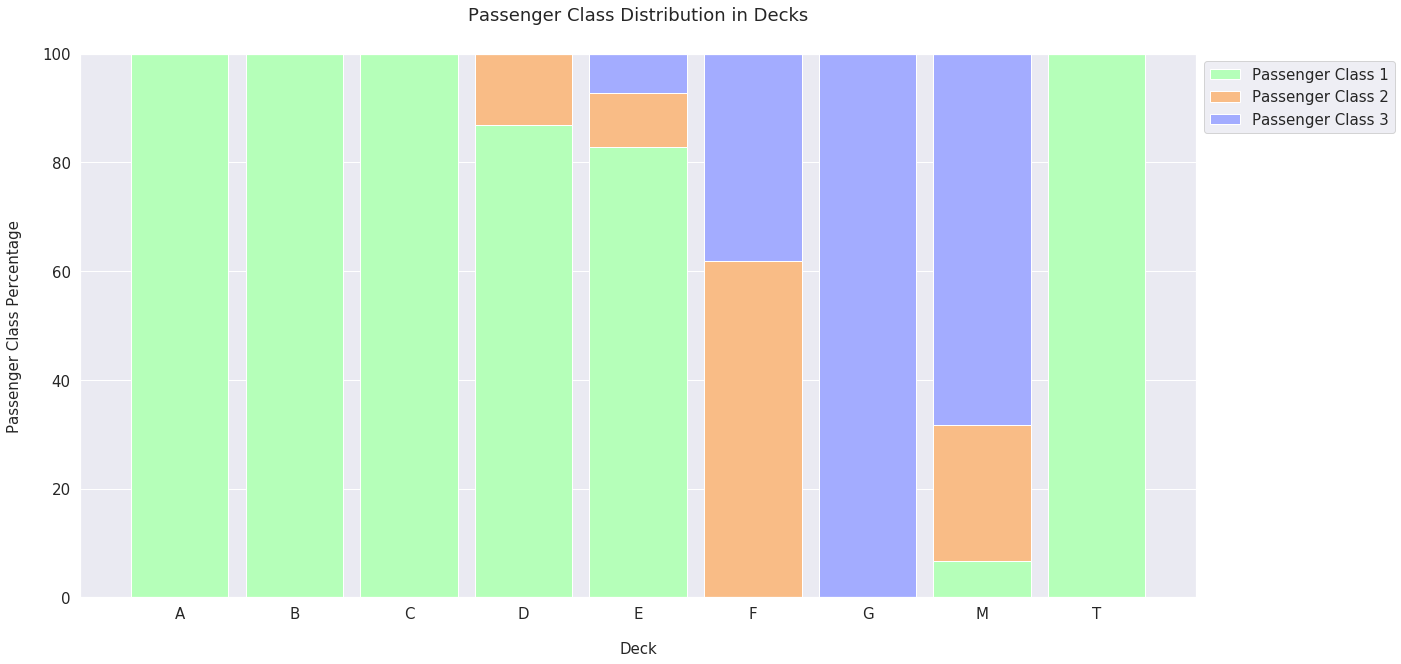

In [13]:
# Creating Deck column from the first letter of the Cabin Column (M stands for missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()
def get_pclass_dist(df):
    # Creating a dict for every passenger class count in every deck
    letters = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    deck_counts = {letter: {} for letter in letters}
    decks = df.columns.levels[0]
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)
    deck_percentages = {}
    
    # Creating a dict for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()
    
all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [14]:
# Move The single passenger at T to A since it is most like the Cabin A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

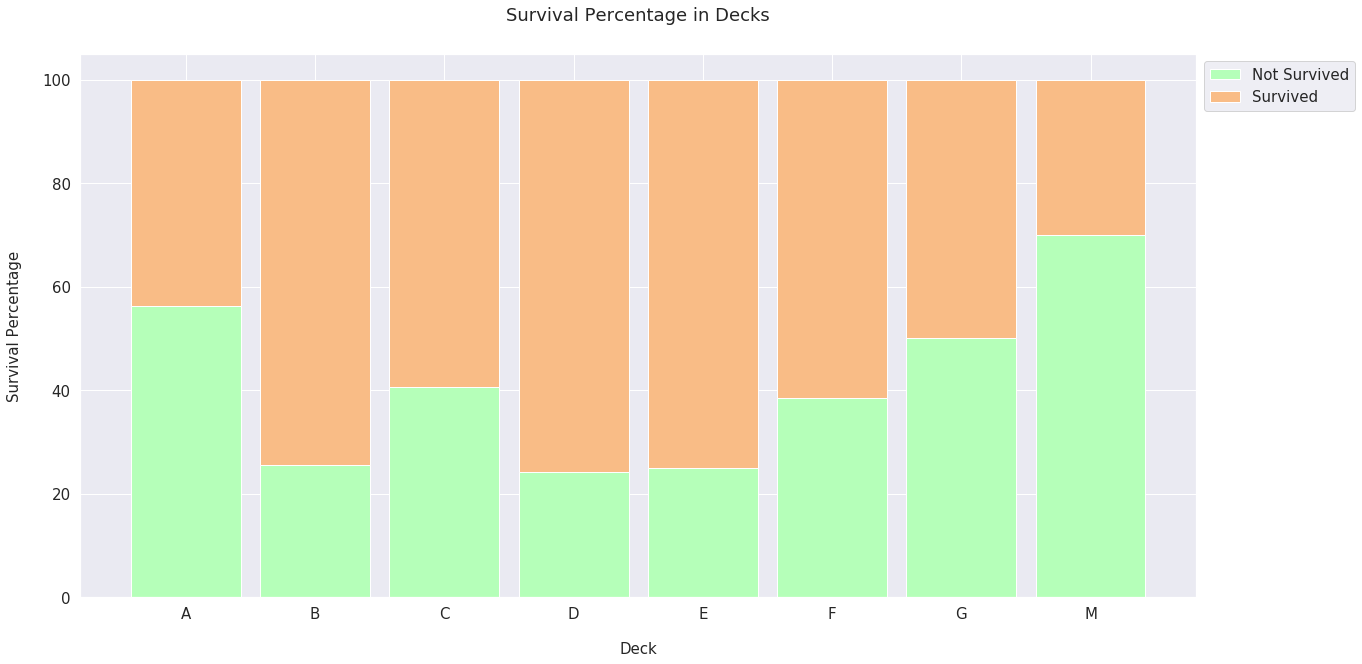

In [15]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

In [16]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [17]:
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0
Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


## Survival Distribution

In [18]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


## Correlations

In [24]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [25]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [26]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Fare,Parch,0.230410
16,SibSp,Fare,0.172032


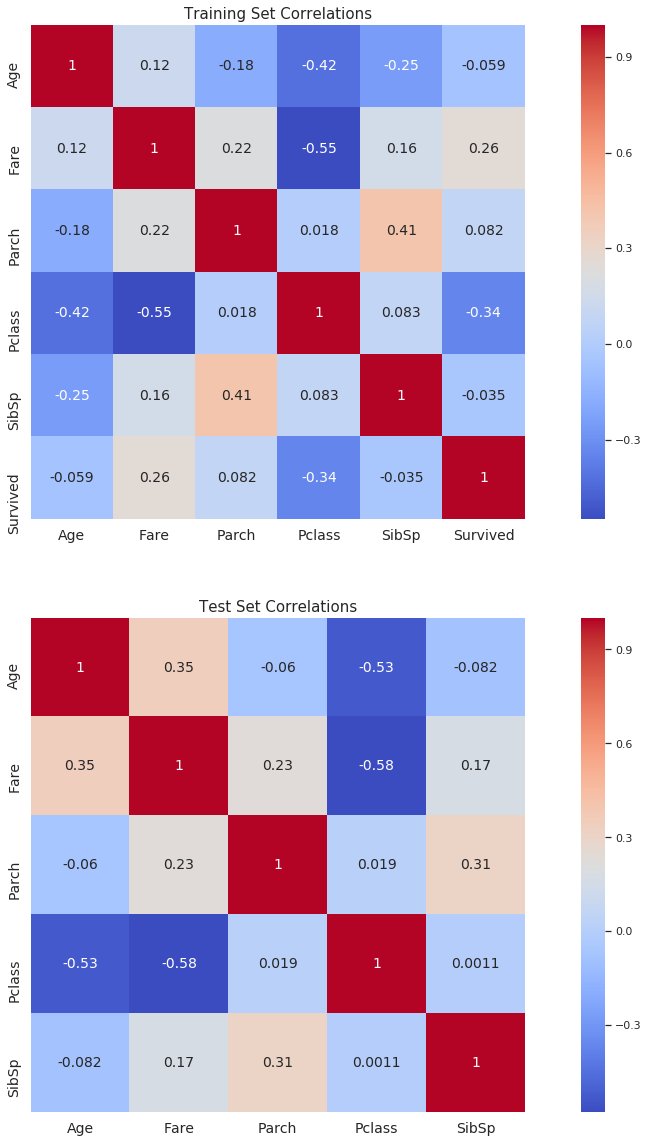

In [28]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size':14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()